到目前为止，我们遇到过两种类型的数据：表格数据和图像数据。对于图像数据，我们设计了专门的卷积神经网络架构来为这类特殊的数据结构建模。换句话说，如果我们拥有一张图像，我们需要有效地利用其像素位置，假若我们对图像中的像素位置进行重排，就会对图像中内容的推断造成极大的困难。

最重要的是，到目前为止我们默认数据都来自于某种分布，并且所有样本都是独立同分布的（independently
and identically distributed，i.i.d.）。然而，大多数的数据并非如此。例如，文章中的单词是按顺序写的，如果顺序被随机地重排，就很难理解文章原始的意思。同样，视频中的图像帧、对话中的音频信号以及网站上的浏览行为都是有顺序的。因此，针对此类数据而设计特定模型，可能效果会更好。

另一个问题来自这样一个事实：我们不仅仅可以接收一个序列作为输入，而是还可能期望继续猜测这个序列的后续。例如，一个任务可以是继续预测2, 4, 6, 8, 10, . . .这在时间序列分析中是相当常见的，可以用来预测股市的波动、患者的体温曲线或者赛车所需的加速度。同理，我们需要能够处理这些数据的特定模型。

简言之，如果说卷积神经网络可以有效地处理空间信息，那么本章的循环神经网络（recurrent neural network，RNN）则可以更好地处理**序列信息**。循环神经网络通过引入状态变量存储过去的信息和当前的输入，从而可以确定当前的输出。

通过以下途径预测$x_t$：$$x_t\sim P(x_t|x_1,x_2,...x_{t-1})$$
为了实现这个预测，交易员可以使用回归模型，例如在 3.3节中训练的模型。仅有一个主要问题：输入数据的数量，输入xt−1, . . . , x1本身因t而异。也就是说，输入数据的数量这个数字将会随着我们遇到的数据量的增加而增加，因此需要一个近似方法来使这个计算变得容易处理。本章后面的大部分内容将围绕着如何有效估计P (xt | xt−1, . . . , x1)展开。简单地说，它归结为以下两种策略。

第一种策略，假设在现实情况下相当长的序列 xt−1, . . . , x1可能是不必要的，因此我们只需要满足某个长度为τ 的时间跨度，即使用观测序列xt−1, . . . , xt−τ 。当下获得的最直接的好处就是参数的数量总是不变的，至少在t > τ 时如此，这就使我们能够训练一个上面提及的深度网络。这种模型被称为自回归模型（autoregressivemodels），因为它们是对自己执行回归。

第二种策略，如 图8.1.2所示，是保留一些对过去观测的总结ht，并且同时更新预测ˆxt和总结ht。这就产生了基于ˆxt = P (xt | ht)估计xt，以及公式ht = g(ht−1, xt−1)更新的模型。由于ht从未被观测到，这类模型也被称为 隐变量自回归模型（latent autoregressive models）。
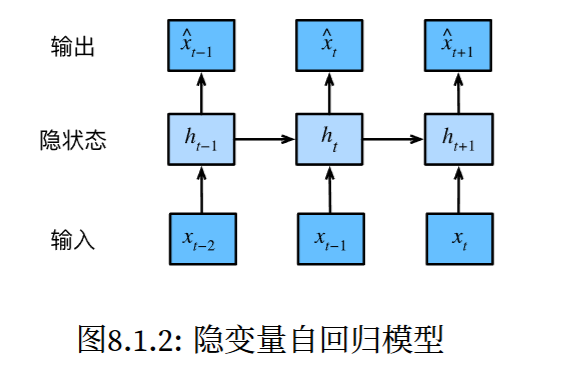

如何生成训练数据？一个经典方法是使用历史观测来预测下一个未来观测。显然，我们并不指望时间会停滞不前。然而，一个常见的假设是虽然特定值xt可能会变，但是序列本身的动力学不会改变。这样的假设是合理的，因为新的动力学一定受新的数据影响，而我们不可能用目前所掌握的数据来预测新的动力学。统计学家称不变的动力学为静止的（stationary）。

Markov模型
- 回想一下，在自回归模型的近似法中，我们使用xt−1, . . . , xt−τ 而不是xt−1, . . . , x1来估计xt。只要这种是近似精确的，我们就说序列满足马尔可夫条件（Markov condition）

In [ ]:
#用正弦函数和一些可加性噪声来生成序列数据，时间步为1, 2, . . . , 1000
%matplotlib inline
import torch 
from torch import nn
from d2l import torch as d2l

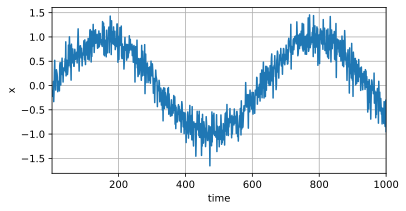

In [14]:
T=1000
time=torch.arange(1,T+1,dtype=torch.float32)
x=torch.sin(0.01*time)+torch.normal(0,0.2,(T,))
d2l.plot(time,[x],'time','x',xlim=[1,1000],figsize=(6,3))

接下来，我们将这个序列转换为模型的特征－标签（feature‐label）对。基于嵌入维度τ ，我们将数据映射为数据对yt = xt 和xt = [xt−τ , . . . , xt−1]。这比我们提供的数据样本少了τ 个，因为我们没有足够的历史记录来描述前τ 个数据样本。一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；另一个方法是用零填充序列。在这里，我们仅使用前600个“特征－标签”对进行训练。

In [15]:
tau=4
features=torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i]=x[i:T-tau+i]
labels=x[tau:].reshape((-1,1))

In [16]:
batch_size,n_train=16,600
#只有前n_train个样本用于训练
train_iter=d2l.load_array((features[:n_train],labels[:n_train]),
                           batch_size,is_train=True)

In [17]:
#在这里，我们使用一个相当简单的架构训练模型：一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        
# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net
# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [18]:
def train(net,train_iter,loss,epochs,lr):
    trainer=torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l=loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net=get_net()
train(net,train_iter,loss,5,0.01)

epoch 1, loss: 0.057309
epoch 2, loss: 0.051892
epoch 3, loss: 0.051462
epoch 4, loss: 0.050507
epoch 5, loss: 0.050812


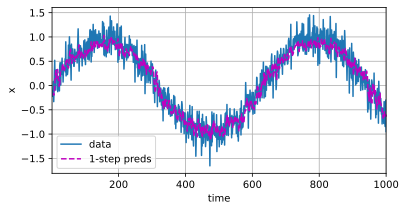

In [19]:
#预测：1.单步预测
onestep_preds=net(features)
d2l.plot([time,time[tau:]],
         [x.detach().numpy(),onestep_preds.detach().numpy()],'time',
         'x',legend=['data','1-step preds'],xlim=[1,1000],
         figsize=(6,3))

通常，对于直到xt的观测序列，其在时间步t + k处的预测输出ˆxt+k 称为k步预测（k‐step‐ahead‐prediction）。由于我们的观察已经到了x604，它的k步预测是ˆx604+k。换句话说，我们必须使用我们自己的预测（而不是原始数据）来进行多步预测。让我们看看效果如何。

In [20]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

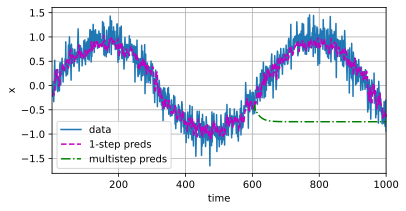

In [21]:
d2l.plot([time,time[tau:],time[n_train+tau:]],
        [x.detach().numpy(),onestep_preds.detach().numpy(),
         multistep_preds[n_train+tau:].detach().numpy()],'time',
         'x',legend=['data','1-step preds','multistep preds'],
         xlim=[1,1000],figsize=(6,3))

过几个预测步骤之后，预测的结果很快就会衰减到一个常数。为什么这个算法效果这么差呢？事实是由于错误的累积：假设在步骤1之后，我们积累了一些错误ε1 =  ̄ε。于是，步骤2的输入被扰动了ε1，结果积累的误差是依照次序的ε2 =  ̄ε + cε1，其中c为某个常数，后面的预测误差依此类推。因此误差可能会相当快地偏离真实的观测结果。

In [22]:
#基于k = 1, 4, 16, 64，通过对整个序列预测的计算，下面仔细看一下k步预测的困难。
max_steps=64
features=torch.zeros((T-tau-max_steps+1,tau+max_steps))
#列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:,i]=x[i:i+T-tau-max_steps+1]
# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:,i]=net(features[:,i-tau:i]).reshape(-1)

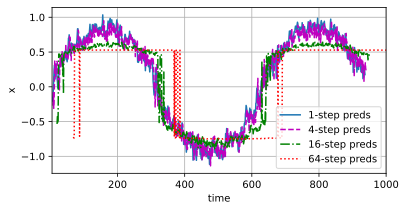

In [23]:
steps=(1,4,16,64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
        [features[:,(tau+i-1)].detach().numpy() for i in steps], 'time', 'x',
        legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
        figsize=(6, 3))

以上例子清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。虽然“4步预测”看起来仍然不错，但超过这个跨度的任何预测几乎都是无用的。

小结
- 内插法（在现有观测值之间进行估计）和外推法（对超出已知观测范围进行预测）在实践的难度上差别很大。因此，对于所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进行训练。
- 序列模型的估计需要专门的统计工具，两种较流行的选择是自回归模型和隐变量自回归模型。
- 对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。
- 对于直到时间步t的观测序列，其在时间步t + k的预测输出是“k步预测”。随着我们对预测时间k值的增加，会造成误差的快速累积和预测质量的极速下降。

#### 8.2 文本预处理
对于序列数据处理问题，我们在 8.1节中评估了所需的统计工具和预测时面临的挑战。这样的数据存在许多种形式，文本是最常见例子之一。例如，一篇文章可以被简单地看作一串单词序列，甚至是一串字符序列。本节中，我们将解析文本的常见预处理步骤。这些步骤通常包括：
1. 将文本作为字符串加载到内存中。
2. 将字符串拆分为词元（如单词和字符）。
3. 建立一个词表，将拆分的词元映射到数字索引。
4. 将文本转换为数字索引序列，方便模型操作。

In [24]:
import collections
import re
from d2l import torch as d2l

In [ ]:
#下面的函数将数据集读取到由多条文本行组成的列表中，其中每条文本行都是一个字符串。为简单起见，我们在这里忽略了标点符号和字母大写。
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
'090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine(): #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
#strip()去除开头和结尾的空格,lower方法将所有字母转化为小写
lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


#### 词元化
下面的tokenize函数将文本行列表（lines）作为输入，列表中的每个元素是一个文本序列（如一条文本行）。每个文本序列又被拆分成一个词元列表，词元（token）是文本的基本单位。最后，返回一个由词元列表组成的列表，其中的每个词元都是一个字符串（string）。

In [31]:
#词元化
def tokenize(lines,token='word'):
    """将文本行拆分为单词或字符词元"""
    if token=='word':
        return [line.split() for line in lines]
    elif token=='char':
        return [list(line) for line in lines]
    else:
        print("错误:未知词元类型: "+token)

In [32]:
tokens=tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


#### 词表
词元的类型是字符串，而模型需要的输入是数字，因此这种类型不方便模型使用。现在，让我们构建一个字典，通常也叫做词表（vocabulary），用来将字符串类型的词元映射到从0开始的数字索引中。我们先将训练集中的所有文档合并在一起，对它们的唯一词元进行统计，得到的统计结果称之为语料（corpus）。然后根据每个唯一词元的出现频率，为其分配一个数字索引。很少出现的词元通常被移除，这可以降低复杂性。另外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元“unk”。我们可以选择增加一个列表，用于保存那些被保留的词元，例如：填充词元（“pad”）；序列开始词元（“bos”）；序列结束词元（“eos”）。

In [35]:
class Vocab:#@save
    """文本词表"""
    def __init__(self,tokens=None,min_freq=0,reserved_tokens=None):
        if tokens is None:
            tokens=[]
        if reserved_tokens is None:
                reserved_tokens=[]
        #按出现频率排序
        counter=count_corpus(tokens)
        self._token_freqs=sorted(counter.items(),key=lambda x:x[1],
                                     reverse=True)
        #未知词元的索引为0
        self.idx_to_token=['<unk>']+reserved_tokens
        self.token_to_idx={token:idx
                            for idx,token in enumerate(self.idx_to_token)}
        for token,freq in self._token_freqs:
            if freq<min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token]=len(self.idx_to_token)-1

    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self,tokens):
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token)for token in tokens]
    
    def to_tokens(self,indices):
        if not isinstance(indices,(list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index]for index in indices]
    
    @property
    #@property是Python中的一个装饰器，把一个方法变成一个属性（像字段一样访问）
    def unk(self):#未知词元的索引为0
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):#@save
    """统计词元频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


In [37]:
#我们首先使用时光机器数据集作为语料库来构建词表，然后打印前几个高频词元及其索引
vocab=Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [38]:
#现在将每一条文本行转换成一个数字索引列表
for i in [0,10]:
    print('文本:',tokens[i])
    print('索引:',vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [40]:
def load_corpus_time_machine(max_tokens=-1):#@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines=read_time_machine()
    tokens=tokenize(lines,'char')
    vocab=Vocab(tokens)
    #因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    #所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus,vocab=load_corpus_time_machine()
len(corpus),len(vocab)

(170580, 28)

小结
- 文本是序列数据的一种最常见的形式之一。
- 为了对文本进行预处理，我们通常将文本拆分为词元，构建词表将词元字符串映射为数字索引，并将文本数据转换为词元索引以供模型操作。

- 假设长度为T 的文本序列中的词元依次为x1, x2, . . . , xT 。于是，xt（1 ≤ t ≤ T ）可以被认为是文本序列在时间步t处的观测或标签。在给定这样的文本序列时，语言模型（language model）的目标是估计序列的联合概率P (x1, x2, . . . , xT ).
- 为了训练语言模型，我们需要计算单词的概率，以及给定前面几个单词后出现某个单词的条件概率。这些概率本质上就是语言模型的参数。
- 。如果P (xt+1 | xt, . . . , x1) = P (xt+1 | xt)，则序列上的分布满足一
阶马尔可夫性质。阶数越高，对应的依赖关系就越长.通常，涉及一个、两个和三个变量的概率公式分别被称为 一元语法（unigram）、二元语法（bigram）和三元语法（trigram）模型。

In [42]:
import random
import torch
from d2l import torch as d2l

tokens=d2l.tokenize(read_time_machine())
#因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)

vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

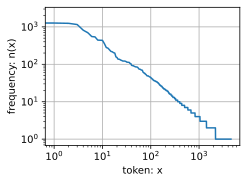

In [ ]:
#正如我们所看到的，最流行的词看起来很无聊，这些词通常被称为停用词（stop words），因此可以被过滤掉。尽管如此，它们本身仍然是有意义的，我们仍然会在模型中使用它们。此外的问题是词频衰减速度相当快，为了更好地理解，我们可以画出的词频图：
freqs=[freq for token,freq in vocab.token_freqs]
d2l.plot(freqs,xlabel='token: x',ylabel='frequency: n(x)',
         xscale='log',yscale='log')
#通过此图我们可以发现：词频以一种明确的方式迅速衰减。将前几个单词作为例外消除后，剩余的所有单词大致遵循双对数坐标图上的一条直线。这意味着单词的频率满足齐普夫定律（Zipf’s law），即第i个最常用单词的频率ni为：ni ∝ 1/i^α 

等价于：

log ni = −α log i + c, (8.3.8)

其中α是刻画分布的指数，c是常数。这告诉我们想要通过计数统计和平滑来建模单词是不可行的，因为这样建模的结果会大大高估尾部单词的频率，也就是所谓的不常用单词。那么其他的词元组合，比如二元语法、三元语法等等，又会如何呢？我们来看看二元语法的频率是否与一元语法的频率表现出相同的行为方式。

In [45]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [46]:
#这里值得注意：在十个最频繁的词对中，有九个是由两个停用词组成的，只有一个与“the time”有关。我们再进一步看看三元语法的频率是否表现出相同的行为方式。
trigram_tokens=[triple for triple in zip(corpus[:-2],corpus[1:-1],corpus[2:])]
trigram_vocab=Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

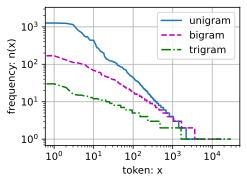

In [47]:
#最后，我们直观地对比三种模型中的词元频率：一元语法、二元语法和三元语法
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
        ylabel='frequency: n(x)', xscale='log', yscale='log',
        legend=['unigram', 'bigram', 'trigram'])

这张图非常令人振奋！原因有很多：
1. 除了一元语法词，单词序列似乎也遵循齐普夫定律，尽管公式 (8.3.7)中的指数α更小（指数的大小受序
列长度的影响）；
2. 词表中n元组的数量并没有那么大，这说明语言中存在相当多的结构，这些结构给了我们应用模型的希
望；
3. 很多n元组很少出现，这使得拉普拉斯平滑非常不适合语言建模。作为代替，我们将使用基于深度学习
的模型。

随机采样

在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列。在迭代过程中，来自两个相邻的、随机
的、小批量中的子序列不一定在原始序列上相邻。对于语言建模，目标是基于到目前为止我们看到的词元来
预测下一个词元，因此标签是移位了一个词元的原始序列。
下面的代码每次可以从数据中随机生成一个小批量。在这里，参数batch_size指定了每个小批量中子序列样
本的数目，参数num_steps是每个子序列中预定义的时间步数。

In [48]:
def seq_data_iter_random(corpus,batch_size,num_steps):#@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，来自两个相邻随机小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)
    
    def data(pos):
        #返回从pos位置开始的长度为num_steps的序列
        return corpus[pos:pos+num_steps]
    num_batches=num_subseqs//batch_size
    for i in range(0,batch_size*num_batches,batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch=initial_indices[i:i+batch_size]
        X=[data(j) for j in initial_indices_per_batch]
        Y=[data(j+1) for j in initial_indices_per_batch]
        yield torch.tensor(X),torch.tensor(Y)

In [49]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 9, 10, 11, 12, 13],
        [14, 15, 16, 17, 18]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
X:  tensor([[24, 25, 26, 27, 28],
        [ 4,  5,  6,  7,  8]]) 
Y: tensor([[25, 26, 27, 28, 29],
        [ 5,  6,  7,  8,  9]])
X:  tensor([[29, 30, 31, 32, 33],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[30, 31, 32, 33, 34],
        [20, 21, 22, 23, 24]])


在迭代过程中，除了对原始序列可以随机抽样外，我们还可以保证两个相邻的小批量中的子序列在原始序列上也是相邻的。这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为顺序分区。

In [50]:
def seq_data_iter_sequential(corpus, batch_size, num_steps): #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [52]:
#基于相同的设置，通过顺序分区读取每个小批量的子序列的特征X和标签Y。
for X,Y in seq_data_iter_sequential(my_seq,batch_size=2,num_steps=5):
    print('X: ',X,'\nY:',Y)

X:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


In [53]:
class SeqDataLoader: #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [ ]:
def load_data_time_machine(batch_size, num_steps, #@save
                            use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

小结
- 语言模型是自然语言处理的关键。
- n元语法通过截断相关性，为处理长序列提供了一种实用的模型。
- 长序列存在一个问题：它们很少出现或者从不出现。
- 齐普夫定律支配着单词的分布，这个分布不仅适用于一元语法，还适用于其他n元语法。
- 通过拉普拉斯平滑法可以有效地处理结构丰富而频率不足的低频词词组。
- 读取长序列的主要方式是随机采样和顺序分区。在迭代过程中，后者可以保证来自两个相邻的小批量中的子序列在原始序列上也是相邻的。